In [162]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

In [163]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [164]:
batch_size = 16
img_size = 128
patch_size = 8
num_channels = 3
num_patches = (img_size // patch_size) ** 2

embed_dim = 8
mlp_dim = 16

mlp_nodes = 128

num_classes = 2

transformer_blocks = 4
attention_heads = 4

In [165]:
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed = nn.Conv2d(num_channels,embed_dim,kernel_size=patch_size,stride=patch_size)

  def forward(self, x):
      return self.patch_embed(x).flatten(2).transpose(1,2)

In [166]:
#TransformerArchitecture of ViT
class TransformerArchitecture(nn.Module):
  def __init__(self):
    super().__init__()
    self.layernorm1 = nn.LayerNorm(embed_dim)
    self.self_attention = nn.MultiheadAttention(embed_dim,num_heads=attention_heads,dropout=0.2,batch_first=True)
    self.layernorm2 = nn.LayerNorm(embed_dim)
    self.mlp = nn.Sequential(
        nn.Linear(embed_dim,mlp_dim),
        nn.GELU(),
         nn.Dropout(0.2),
        nn.Linear(mlp_dim,embed_dim)
    )

  def forward(self,x):
    residual1 = x
    x = self.self_attention(self.layernorm1(x),self.layernorm1(x),self.layernorm1(x))[0] + residual1
    residual2 = x
    x = self.mlp(self.layernorm2(x)) + residual2
    return x

In [167]:
class MLP_Head(nn.Module):
  def __init__(self):
    super().__init__()
    self.layernorm1 = nn.LayerNorm(embed_dim)
    self.mlphead = nn.Sequential(
        #nn.Linear(embed_dim),
        nn.Linear(embed_dim,num_classes),
         nn.Dropout(0.2)
    )

  def forward(self,x):
    x = x[:,0] # only cls(classification token)
    x = self.layernorm1(x)
    x = self.mlphead(x)
    return x

In [168]:
class ViT(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    self.position_embedding = nn.Parameter(torch.randn(1, (img_size // patch_size) ** 2 + 1, embed_dim))
    self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
    self.transformer_blocks = nn.Sequential(*[TransformerArchitecture()for _ in  range(transformer_blocks)])
    self.mlphead = MLP_Head()

  def forward(self,x):
    x = self.patch_embedding(x)
    B = x.shape[0]
    cls_tokens = self.cls_token.expand(B,-1,-1)
    x = torch.cat((cls_tokens, x), dim=1)
    x = x + self.position_embedding
    x = self.transformer_blocks(x)
    x = self.mlphead(x)
    return x


In [169]:
dataset = "/content/drive/MyDrive/datasets/brain_tumor/brain_tumor_dataset"

In [170]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

In [171]:
from torchvision import datasets, transforms

full_dataset = datasets.ImageFolder(root=dataset)

In [172]:
indices = np.arange(len(full_dataset))
labels = [full_dataset[i][1] for i in indices]

In [173]:
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)

In [174]:
train_dataset = Subset(full_dataset, train_idx)
test_dataset = Subset(full_dataset, test_idx)

train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Classes:", full_dataset.classes)
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Classes: ['no', 'yes']
Train samples: 202
Test samples: 51


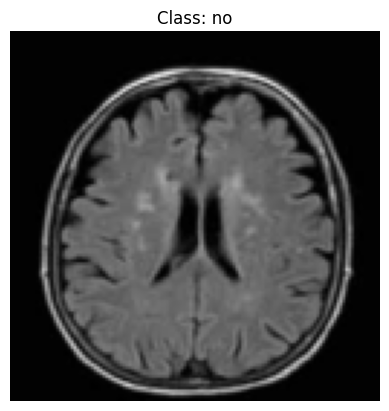

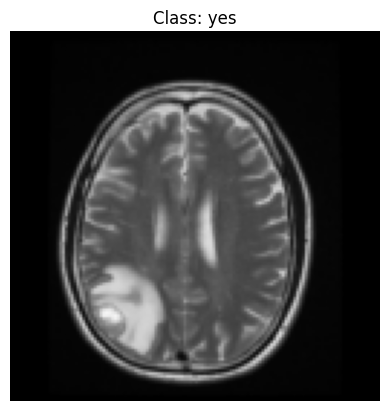

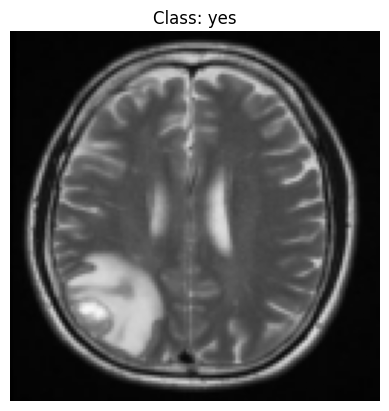

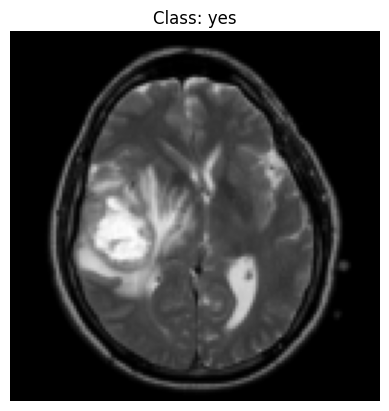

In [175]:
import matplotlib.pyplot as plt

def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.show()

# Bir batch çekelim
dataiter = iter(train_loader)
images, labels = next(dataiter)

# İlk 4 resmi göster
for i in range(4):
    imshow(images[i], title=f"Class: {full_dataset.classes[labels[i]]}")


In [176]:
images[1].shape

torch.Size([3, 128, 128])

In [186]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

model = ViT()
learning_rate = 0.00005

optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
loss_func = nn.CrossEntropyLoss()

epochs = 50

In [187]:
for epoch in range(epochs):
  model.to(device)
  model.train()
  total_loss = 0
  correct_epoch = 0
  total_epoch = 0
  print(f"\nEpoch {epoch+1}")

  for batch_idx,(images,labels) in enumerate(train_loader):
    images,labels = images.to(device),labels.to(device)

    optimizer.zero_grad()
    pred = model(images)

    loss = loss_func(pred,labels)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
    preds = pred.argmax(dim=1)

    correct = (preds==labels).sum().item()
    accuracy = 100*correct/labels.size(0)

    correct_epoch+=correct
    total_epoch+=labels.size(0)

    #if batch_idx % 100 == 0:
            #print(f"  Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

  epoch_acc = 100.0 * correct_epoch / total_epoch
  print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")






Epoch 1
==> Epoch 1 Summary: Total Loss = 6.9989, Accuracy = 76.24%

Epoch 2
==> Epoch 2 Summary: Total Loss = 7.0223, Accuracy = 71.29%

Epoch 3
==> Epoch 3 Summary: Total Loss = 7.0722, Accuracy = 75.74%

Epoch 4
==> Epoch 4 Summary: Total Loss = 7.7575, Accuracy = 67.82%

Epoch 5
==> Epoch 5 Summary: Total Loss = 7.1383, Accuracy = 75.74%

Epoch 6
==> Epoch 6 Summary: Total Loss = 7.0395, Accuracy = 72.77%

Epoch 7
==> Epoch 7 Summary: Total Loss = 7.2860, Accuracy = 70.30%

Epoch 8
==> Epoch 8 Summary: Total Loss = 7.1432, Accuracy = 73.27%

Epoch 9
==> Epoch 9 Summary: Total Loss = 6.8154, Accuracy = 73.76%

Epoch 10
==> Epoch 10 Summary: Total Loss = 6.9940, Accuracy = 74.75%

Epoch 11
==> Epoch 11 Summary: Total Loss = 6.8398, Accuracy = 75.74%

Epoch 12
==> Epoch 12 Summary: Total Loss = 7.1213, Accuracy = 70.79%

Epoch 13
==> Epoch 13 Summary: Total Loss = 6.8898, Accuracy = 73.76%

Epoch 14
==> Epoch 14 Summary: Total Loss = 6.6461, Accuracy = 72.28%

Epoch 15
==> Epoch 15 S

In [188]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"\n==> Val Accuracy: {test_acc:.2f}%")



==> Val Accuracy: 76.47%


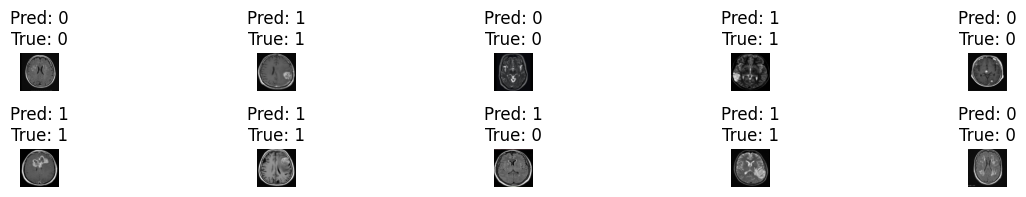

In [189]:
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Plot 10 test images with predictions
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze().permute(1, 2, 0).cpu())
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [199]:
class CNN(nn.Module):
  def __init__(self,input_features,output_features,hidden_units):
    super().__init__()
    self.conv_block1 = nn.Sequential(
      nn.Conv2d(in_channels = input_features,
                out_channels = hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2
                ))
    self.conv_block2 = nn.Sequential(
      nn.Conv2d(in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2
                ))

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Dropout(0.2),
      nn.Linear(in_features=hidden_units*32*32, out_features=output_features),
    )


  def forward(self,x):
      x = self.conv_block1(x)
      x = self.conv_block2(x)
      x = self.classifier(x)
      return x


In [200]:
num_classes

2

In [201]:
model2 = CNN(input_features=3,
    hidden_units=64,
    output_features=num_classes).to(device)
model2

CNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=65536, out_features=2, bias=True)
  )
)

In [202]:
learning_rate = 0.0005
optimizer = torch.optim.Adam(model2.parameters(),lr = learning_rate)
loss_func = nn.CrossEntropyLoss()
epochs=10


for epoch in range(epochs):
  model2.to(device)
  model2.train()
  total_loss = 0
  correct_epoch = 0
  total_epoch = 0
  print(f"\nEpoch {epoch+1}")

  for batch_idx,(images,labels) in enumerate(train_loader):
    images,labels = images.to(device),labels.to(device)

    optimizer.zero_grad()
    pred = model2(images)

    loss = loss_func(pred,labels)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
    preds = pred.argmax(dim=1)

    correct = (preds==labels).sum().item()
    accuracy = 100*correct/labels.size(0)

    correct_epoch+=correct
    total_epoch+=labels.size(0)

    #if batch_idx % 100 == 0:
            #print(f"  Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

  epoch_acc = 100.0 * correct_epoch / total_epoch
  print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")






Epoch 1
==> Epoch 1 Summary: Total Loss = 9.0267, Accuracy = 54.46%

Epoch 2
==> Epoch 2 Summary: Total Loss = 7.9418, Accuracy = 72.28%

Epoch 3
==> Epoch 3 Summary: Total Loss = 6.7668, Accuracy = 78.22%

Epoch 4
==> Epoch 4 Summary: Total Loss = 5.9727, Accuracy = 78.71%

Epoch 5
==> Epoch 5 Summary: Total Loss = 5.5858, Accuracy = 79.70%

Epoch 6
==> Epoch 6 Summary: Total Loss = 4.9070, Accuracy = 83.66%

Epoch 7
==> Epoch 7 Summary: Total Loss = 4.3519, Accuracy = 85.15%

Epoch 8
==> Epoch 8 Summary: Total Loss = 2.8486, Accuracy = 92.57%

Epoch 9
==> Epoch 9 Summary: Total Loss = 1.7548, Accuracy = 97.52%

Epoch 10
==> Epoch 10 Summary: Total Loss = 1.7279, Accuracy = 95.54%


In [203]:
model2.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"\n==> Val Accuracy: {test_acc:.2f}%")



==> Val Accuracy: 86.27%


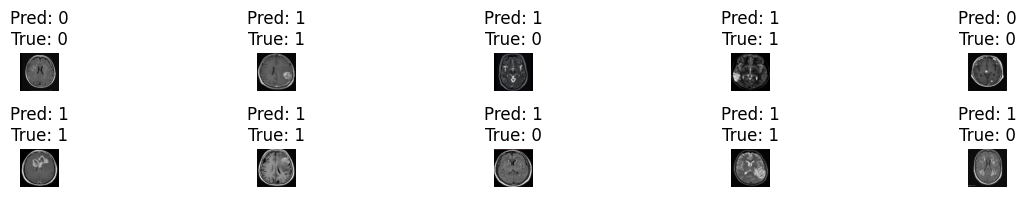

In [204]:
model2.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model2(images)
    preds = outputs.argmax(dim=1)

# Plot 10 test images with predictions
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze().permute(1, 2, 0).cpu())
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()